# GAN - Create Probabilistic Distribution
- Fully connected  layer GAN

![GAN](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11000153/g1.jpg)

In [1]:
%matplotlib inline
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

/Users/skim0119/venv/GenP3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/skim0119/venv/GenP3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare Data

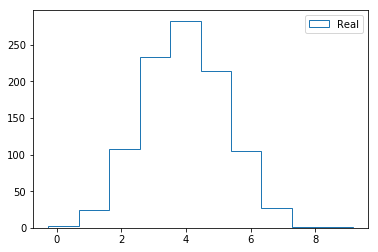

In [2]:
data_mean = 4
data_stddev = 1.25
ni_D=100

real_sample = lambda n_batch: np.random.normal(data_mean, data_stddev, (n_batch, ni_D))
in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

plt.hist(real_sample(10).reshape(-1), histtype='step', label='Real')
plt.legend(loc=0)
plt.show()

## Model

In [3]:
adam = Adam(lr=0.0002, beta_1=0.9, beta_2=0.999)
def set_compile(model):
    return model.compile(loss='binary_crossentropy',
                         optimizer=Adam(lr=0.0002, beta_1=0.9, beta_2=0.999),
                         metrics=['accuracy'])

# set dimension
disc_inp = 100
disc_hid = 50
gene_hid = 50

In [4]:
def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

### Generator Network

In [5]:
gen_model = Sequential()  # (Batch, disc_inp)
gen_model.add(Reshape((disc_inp, 1), input_shape=(disc_inp,)))  # (Batch, steps=disc_inp, input_dim=1)
gen_model.add(Conv1D(gene_hid, 1, activation='relu'))  # (Batch, disc_inp, gene_hid)
gen_model.add(Conv1D(gene_hid, 1, activation='sigmoid'))  # (Batch, disc_inp, gene_hid)
gen_model.add(Conv1D(1, 1))  # (Batch, disc_inp, 1)
gen_model.add(Flatten())  # (Batch, disc_inp)

set_compile(gen_model)

### Discriminator Network

In [6]:
dis_model = Sequential()
dis_model.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(disc_inp,)))
dis_model.add(Dense(disc_hid, activation='relu'))
dis_model.add(Dense(disc_hid, activation='relu'))
dis_model.add(Dense(1, activation='sigmoid'))

set_compile(dis_model)

### Generator + Discriminator Network

In [8]:
total_model = Sequential()
total_model.add(gen_model)
total_model.add(dis_model)
dis_model.trainable = False
set_compile(total_model)
dis_model.trainable = True

## Training

In [16]:
def discriminator_train_on_batch(Real, Gen):
    X = np.concatenate([Real, Gen], axis=0)
    y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
    dis_model.train_on_batch(X, y)

def total_train_on_batch(Z):
    y = np.array([1] * Z.shape[0])
    total_model.train_on_batch(Z, y)

In [22]:
n_batch = 1
n_iter_D = 1
n_iter_G = 5

def train(epochs):
    for epoch in range(epochs):
        # Train Discriminator
        for i in range(n_iter_D):
            r = real_sample(n_batch)
            z = in_sample(n_batch)  # input sample
            predict = gen_model.predict(z)

            dis_model.trainable = True
            discriminator_train_on_batch(r, predict)
            
        # Train Generator after
        for i in range(n_iter_G):
            z = in_sample(n_batch)
            dis_model.trainable = False
            total_train_on_batch(z)

def visualize(n_test):
    z = in_sample(n_test)
    predict = gen_model.predict(z)
    r = real_sample(n_test)
    
    plt.hist(r.reshape(-1), histtype='step', label='Real')
    plt.hist(predict.reshape(-1), histtype='step', label='Generated')
    plt.legend(loc=0)
    plt.show()
    
    def stat(d):
        return (np.mean(d), np.std(d))
    print('Mean and Std of Real:', stat(r))
    print('Mean and Std of Gen:', stat(predict))

Stage 0 (Epoch: 0)


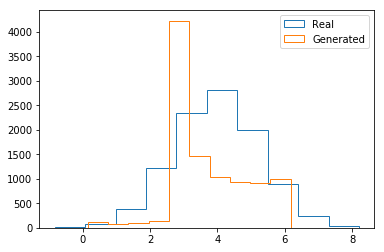

Mean and Std of Real: (3.9920404812654584, 1.2518453939793572)
Mean and Std of Gen: (3.7483141, 1.1435589)
Stage 1 (Epoch: 200)


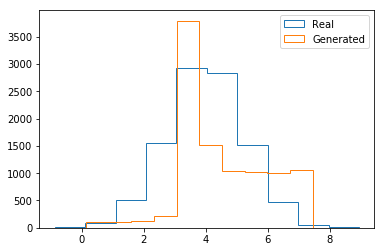

Mean and Std of Real: (4.003609224147254, 1.2455568534388024)
Mean and Std of Gen: (4.5285892, 1.4475269)
Stage 2 (Epoch: 400)


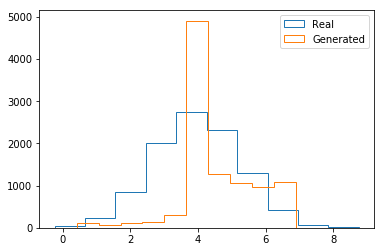

Mean and Std of Real: (3.9866270469064227, 1.2743912668168718)
Mean and Std of Gen: (4.484225, 1.1526686)
Stage 3 (Epoch: 600)


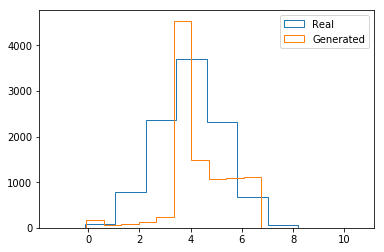

Mean and Std of Real: (3.990701220602339, 1.2584688319595594)
Mean and Std of Gen: (4.331857, 1.2249613)
Stage 4 (Epoch: 800)


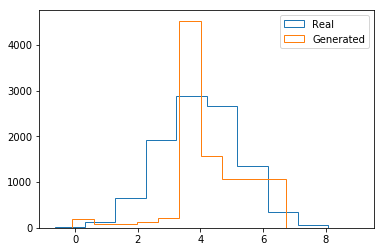

Mean and Std of Real: (4.006701054835786, 1.2364732133968397)
Mean and Std of Gen: (4.288966, 1.2357178)
Stage 5 (Epoch: 1000)


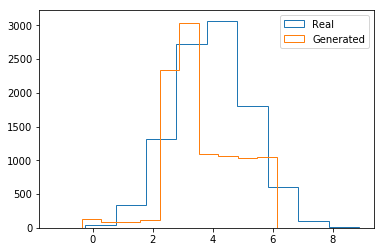

Mean and Std of Real: (3.98123654530962, 1.2511671038644507)
Mean and Std of Gen: (3.6527653, 1.2039785)
Stage 6 (Epoch: 1200)


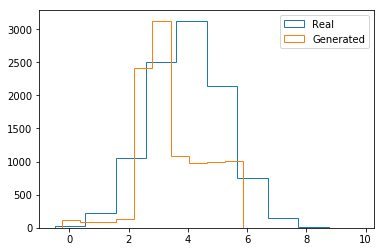

Mean and Std of Real: (3.998156695082769, 1.2570686983417854)
Mean and Std of Gen: (3.5037136, 1.116266)
Stage 7 (Epoch: 1400)


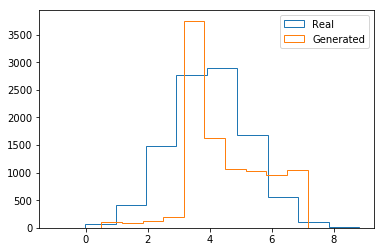

Mean and Std of Real: (3.9910847495596995, 1.2487734996486988)
Mean and Std of Gen: (4.5391736, 1.2696744)
Stage 8 (Epoch: 1600)


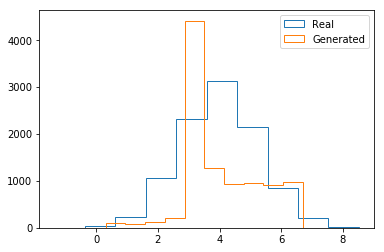

Mean and Std of Real: (3.9960480607137097, 1.255962040470575)
Mean and Std of Gen: (4.0073123, 1.281712)
Stage 9 (Epoch: 1800)


KeyboardInterrupt: 

In [23]:
n_repeat=200
n_show=200
n_test=100
for i in range(n_repeat):
    print('Stage', i, '(Epoch: {})'.format(i * n_show))

    train(n_show)
    if n_repeat % 20 == 0: visualize(n_test)

    plt.show()